
<span style="color:orange; font-size:35px;"> Signature de trajectoires & classification de séries temporelles</span>


En finance les séries temporelles sont d'une véritable importance et il n'est pas rare que ces séries soient injectés dans des modèles de machine learning à des fin de prédiction/modélisation .

Dans le cadre du projet de recherche d'élaboration de stratégies de trading avec la notion de signature de trajectoires , nous faisons ici un petit apatheid afin d'illustrer le potentiel de la signature dans une tâche classique en machine learning : la classification de séries temporelles.

L'essentiel de l'approche qui sera adoptée , se base sur la théorie fournit dans le rapport du projet.

<span style="color:orange; font-size:22px;"> Objectif : </span>

Notre but est de monter la pertinence de la signature de trajectoire comme *feature* pour une classification . Les points clés sont les suivants : 

A) Générer des échantillons de données suivants un certain processus ARMA (ce qu'on cherche à classifier);

B) Leur attribuer des étiquettes ;

C) Elaboration d'un modèle de regression logistique qui prend comme input la signature tronquée de notre trajectoire ;

D) Comparaison avec un réseau de neurones ;

E) Analyse de sensibilités .


<span style="color:orange; font-size:22px;"> Etape 0 : librairies</span>

In [3]:
#pip install statsmodels


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#pour générer de la data selon ARMA(p,q)

from statsmodels.tsa.arima_process import arma_generate_sample

# utiles pour la classif.

from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# pour le calcul de la signature
import torch 
import signatory 

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,5)
seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

<span style="color:orange; font-size:22px;"> Etape 1 : préparation de la data </span>

On commence par générer deux classes de données qui seront étiqueté dans la suite. 


<span style="color:orange; font-size:18px;"> Rappel </span>


Soit un processus stochastique $Y=(Y_{t})_{t \in \mathbb{Z}} \subset  \mathcal{L}^{2}(\Omega,\mathcal{F},\mathbb{P}) $ stationnaire (espérance et fonction d'auto-covariance ne dépendent pas du temps) et $\epsilon=(\epsilon_{t})_{t \in \mathbb{Z}}$ un bruit blanc (processus stationnaire avec $\mathbb{E}(\epsilon_{t}) = 0$ et $\mathbb{V}(\epsilon_{t}) = \sigma_{\epsilon}^2>0 ,Cov(\epsilon_{t},\epsilon_{s})=0 , \forall t \neq s  ).$

a) On dit que Y suit un modèle AR(p) si :

- $ \exist$     $\epsilon$ , un bruit blanc ; $\phi_{1},...,\phi_{p} \in \mathbb{R}$ ($\phi_{0}=1$ par convention) , tel que :
- $\sum_{j=0}^{p}{\phi_j Y_{t-j}}=\epsilon_{t}$

a) On dit que Y suit un modèle MA(q) si :

- $ \exist$     $\epsilon$ , un bruit blanc ; $\psi_{1},...,\psi_{q} \in \mathbb{R}$ ($\psi_{0}=1$) , tel que :
- $\sum_{k=0}^{p}{\psi_j \epsilon_{t-k}}=Y_{t}$

c) On dit que Y suit un modèle ARMA(p,q) si :

- $ \exist$     $\epsilon$ , un bruit blanc ;
- $\exist$ $\psi_{1},...,\psi_{q}  \in \mathbb{R}$ ($\psi_{0}=1$) 
- $\exist$ $\phi_{1},...,\phi_{p} \in \mathbb{R}$ ($\phi_{0}=1$) , tel que :
- $\sum_{j=0}^{p}{\phi_j Y_{t-j}}=\sum_{k=0}^{p}{\psi_j \epsilon_{t-k}}$

<span style="color:orange; font-size:18px;"> Simulation ARMA(2,2) </span>

In [5]:
N = 2000 # nombre d'échantillon ARMA pour chacune des classe 
N_size = 1000 # taille de chaque échantillon


torch.manual_seed(seed)
np.random.seed(2024)

param_classe1 = {'ar': [0.5*2, 0.5], 'ma': [.6*2, 0.6]} # paramètres classe 1
param_classe2 = {'ar': [-0.4*2, -0.4], 'ma': [-0.7*2, -0.7]} # paramètres classe 2


# génération des échantillons

arma_data1 = arma_generate_sample(**param_classe1, nsample=(N, N_size))
arma_data2 = arma_generate_sample(**param_classe2, nsample=(N, N_size))

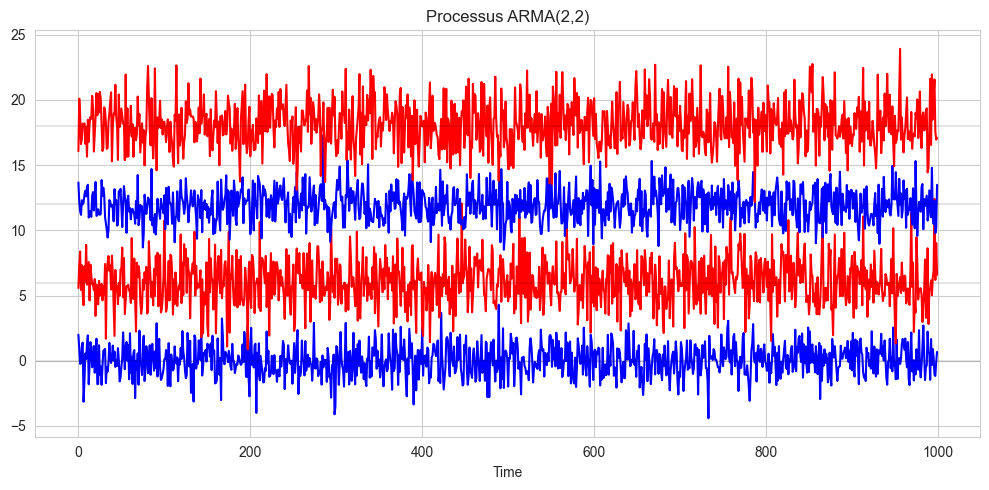

In [6]:
n_plots = 3
fig, ax = plt.subplots(figsize=(10, 5))
vertical_step = 6 # tracer les processus dans la mm fenêtres , plus il y'a de distance , plus les séries seront séparées

for i in range(0,n_plots-1):
    ax.plot(arma_data1[i, :]+(2*i)*vertical_step, color='blue')
    ax.axhline((2*i)*vertical_step, color='black', linestyle='-', alpha=0.1)
    ax.plot(arma_data2[i, :]+(2*i+1)*vertical_step, color='red')
    ax.axhline((2*i+1)*vertical_step, color='black', linestyle='-', alpha=0.1)

#ax.set_yticks([])

ax.set_xlabel('Time')
ax.set_title('Processus ARMA(2,2)')

plt.tight_layout()

<span style="color:orange; font-size:18px;"> Etiquettage </span>

In [9]:
D1,D2 = pd.DataFrame(arma_data1),pd.DataFrame(arma_data2)
D1['type'],D2['type'] = -1 ,1


D = pd.concat([D1, D2], axis=0)

# on mélange la data

D = D.sample(frac=1).reset_index(drop=True)

# split en variables explicatives et cible

X, y = D.iloc[:,:-1], D.iloc[:,-1]

print(f'X shape: {X.shape}')

X shape: (4000, 1000)


<span style="color:orange; font-size:22px;"> Etape 2 : regression logistique sur données brutes vs classification par regression logistique sur les termes de la signature </span>

<span style="color:orange; font-size:16px;"> Fonction pour transformation lead-lag naïve (voir le rapport de projet )</span>

In [10]:
def Naive_LL(data: torch.Tensor) -> torch.Tensor:
    
    path_d = data.repeat_interleave(2, dim=1)  
    lead = path_d[:, 1:, :]  
    lag = path_d[:, :-1, :]  

    LL_ok = torch.cat((lead, lag), dim=2)
    return LL_ok

<span style="color:orange; font-size:16px;"> Fonction pour transformation lead-lag selon Hoff (voir le rapport de projet )</span>

In [11]:
def compute_lead_lag_transform_Hoff_vok(S_t: torch.Tensor):
    
    #X_lead = torch.zeros_like(S_t)
    #X_lag = torch.zeros_like(S_t)
    
    S_extended = S_t.repeat_interleave(2, dim=1) 
    times = torch.linspace(0, 1, steps=S_extended.shape[1])

    X_lead = torch.zeros_like(S_extended)
    X_lag = torch.zeros_like(S_extended)
    N = len(times) // 2
    
    for t in range(2*N-3):
        k = t // 2  # indice de la paire (k, k+1)

        # Calcul de X_lead
        
        if t % 2 == 0:  # t est pair, donc t ∈ [2k, 2k+1]
            
            X_lead[:,t,:] = S_t[:,k + 1,:]
        else:  # t est impair
            if t <= 2 * k + 1:
                X_lead[:,t,:] = S_t[:,k + 1,:] + 2 * (times[t] - times[2 * k + 1]) * (S_t[:,k + 2,:] - S_t[:,k + 1,:])
            else:
                X_lead[:,t,:] = S_t[:,k + 2,:]

        # Calcul de X_lag
        
        if t < 2 * k + 1.5:
            X_lag[:,t,:] = S_t[:,k,:]
        else:
            X_lag[:,t,:] = S_t[:,k + 1,:] + 2 * (times[t] - times[2 * k + 1.5]) * (S_t[:,k + 1,:] - S_t[:,k,:])
            
    LL_transformed = torch.cat((X_lead[:, :-1, :], X_lag[:, :-1, :]), dim=2)
    return LL_transformed #2N points

tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

S_t=compute_lead_lag_transform_Hoff_vok(tensor_arma_data1)
S_t_naive=Naive_LL(tensor_arma_data1)
S_t.shape==S_t_naive.shape

True

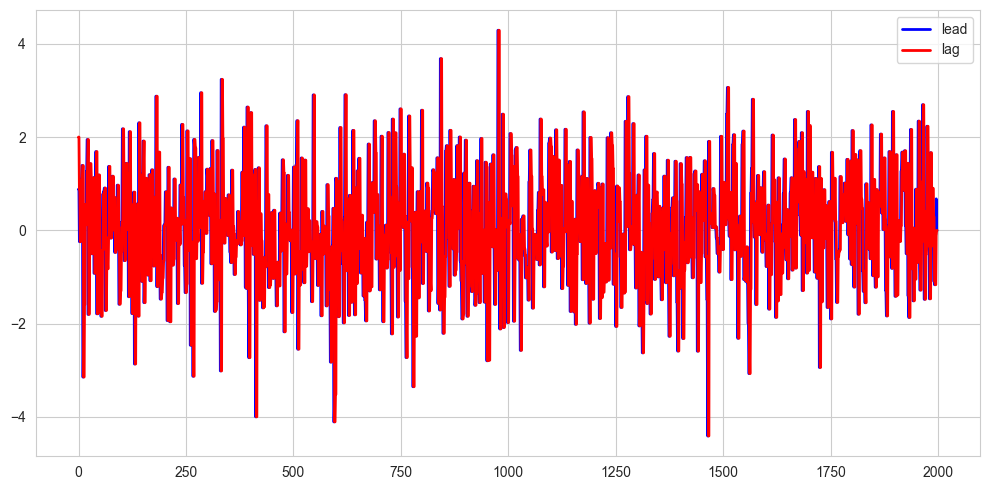

In [12]:
plt.plot( S_t[0,:,0], label='lead', color='blue', linewidth=2)
plt.plot( S_t[0,:,1], label='lag', color='red', linewidth=2)

#plt.plot( S_t_naive[0,:,0], label='lead', color='blue', linewidth=2)
#plt.plot( S_t_naive[0,:,1], label='lag', color='red', linewidth=2)

plt.legend()
plt.grid(True)

#plt.savefig('./img/img.pdf', format='pdf')

plt.tight_layout()
plt.show()

<span style="color:orange; font-size:16px;"> Modèle 1 : regression logistique sur raw data</span>

<span style="color:orange; font-size:14px;"> Avec données brutes </span>

In [13]:
tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

D1,D2 = pd.DataFrame(arma_data1),pd.DataFrame(arma_data2)
D1['type'],D2['type'] = -1,1
D = pd.concat([D1, D2], axis=0)

#etape de shuffle

D= D.sample(frac=1).reset_index(drop=True)

X, y = D.iloc[:,:-1], D.iloc[:,-1]

<span style="color:yellow; font-size:14px;"> Fonction pour regression logistique </span>

In [14]:
def logistic_reg(seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' ):
    model = LogisticRegression(random_state=seed, max_iter=max_iter, solver=solver_types, penalty=penalty)
    cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
    res = cross_val_score(model, predictors, cible, cv=cross_val, scoring='accuracy')
    
    return print('Accuracy: {:.2f} +/- {:.2f}'.format(res.mean(), res.std()))

In [15]:
#avec L1 pénalisation
logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' )

#avec L2 pénalisation

logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l2' )

Accuracy: 0.50 +/- 0.01
Accuracy: 0.50 +/- 0.01


<span style="color:orange; font-size:16px;"> Modèle 2 : classification par regression logistique sur les termes de la signature</span>

<span style="color:orange; font-size:14px;"> Classification Raw data signature </span>

In [16]:
depth = 2 

# signature terms

Sig_data1 = signatory.signature(tensor_arma_data1, depth=depth)
Sig_data2 = signatory.signature(tensor_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)


#avec L1 pénalisation
logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' )

#avec L2 pénalisation

logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l2' )

Accuracy: 0.50 +/- 0.01
Accuracy: 0.50 +/- 0.01


<span style="color:orange; font-size:14px;"> Avec la transformation lead lag naïve + signature</span>

Comme discuté dans le rapport , le temps d'execution pour des grandes valeurs d'ordre de la signature est exponentiel ainsi il est préférable de se restreindre à de petites valeurs de N d'autant plus que nous avons la garantie théorique que les termes de la signature diminuent avec leur rang. 

En d'autres termes, si nous ne considérons  que les premiers termes de la signature , nous ne perdrons pas beaucoup d'informations puisque les termes (d'ordre supérieure) abandonnés ont une décroissance factorielle. Par conséquent, la signature tronquée d'un chemin décrit bien le chemin, et nous pouvons donc l'utiliser comme une caractéristique du chemin.

Nous commençons par une transformation Lead-lag du chemin avant d'effectuer la classification .

In [17]:
depth = 2 
nv_LL_arma_data1 = Naive_LL(tensor_arma_data1)
nv_LL_arma_data2 = Naive_LL(tensor_arma_data2)


# signature terms

Sig_data1 = signatory.signature(nv_LL_arma_data1, depth=depth)
Sig_data2 = signatory.signature(nv_LL_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)

# predictors , variable to explain

X, y = D_sig.iloc[:,:-1], D_sig.iloc[:,-1]

In [18]:
#avec L1 pénalisation
logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' )

#avec L2 pénalisation

logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l2' )

Accuracy: 1.00 +/- 0.00
Accuracy: 1.00 +/- 0.00


<span style="color:orange; font-size:14px;"> Avec la transformation lead lag de Hoff + signature </span>

In [19]:
depth = 2 #
tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

Hoff_LL_arma_data1 = compute_lead_lag_transform_Hoff_vok(tensor_arma_data1)
Hoff_LL_arma_data2 = compute_lead_lag_transform_Hoff_vok(tensor_arma_data2)

torch.manual_seed(seed)
np.random.seed(2024)
# signature terms

Sig_data1 = signatory.signature(Hoff_LL_arma_data1, depth=depth)
Sig_data2 = signatory.signature(Hoff_LL_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)

# predictors , variable to explain

X, y = D_sig.iloc[:,:-1], D_sig.iloc[:,-1]


#avec L1 pénalisation
logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' )

#avec L2 pénalisation

logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l2' )

<span style="color:orange; font-size:22px;"> Etape 3 : Classification par un réseau de neurones sur données brut vs signature des trajectoires</span>

<span style="color:orange; font-size:14px;"> Modèle 1 : neural network without signature transform </span>

<span style="color:orange; font-size:14px;"> Avec données brutes </span>

In [126]:
tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

D1,D2 = pd.DataFrame(arma_data1),pd.DataFrame(arma_data2)
D1['type'],D2['type'] = -1,1
D = pd.concat([D1, D2], axis=0)

#etape de shuffle

D= D.sample(frac=1).reset_index(drop=True)

X, y = D.iloc[:,:-1], D.iloc[:,-1]

<span style="color:yellow; font-size:14px;"> Fonction pour neural network </span>

In [127]:
def nnet(seed,n_neurons=100,predictors=X,cible=y,max_iter= 500):
    
    model = MLPClassifier(hidden_layer_sizes=(n_neurons), max_iter=max_iter, random_state=seed)
    cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
    res = cross_val_score(model, X, y, cv=cross_val, scoring='accuracy')
    
    return print('Accuracy: {:.2f} +/- {:.2f}'.format(res.mean(), res.std()))

In [128]:
#classification par rn avec données brutes
nnet(seed,n_neurons=100,predictors=X,cible=y,max_iter= 500)

Accuracy: 0.56 +/- 0.06


<span style="color:orange; font-size:14px;"> Modèle 2 : neural network with signature transform </span>

<span style="color:orange; font-size:14px;"> Classification Raw data signature </span>

In [129]:
depth = 2 

# signature terms

Sig_data1 = signatory.signature(tensor_arma_data1, depth=depth)
Sig_data2 = signatory.signature(tensor_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)

# signature de données brutes

nnet(seed,n_neurons=100,predictors=X,cible=y,max_iter= 500)

Accuracy: 0.56 +/- 0.06


<span style="color:orange; font-size:14px;"> Avec la transformation lead lag naïve + signature </span>

In [130]:
torch.manual_seed(seed)
np.random.seed(2024)

depth = 2 
nv_LL_arma_data1 = Naive_LL(tensor_arma_data1)
nv_LL_arma_data2 = Naive_LL(tensor_arma_data2)

# signature terms

Sig_data1 = signatory.signature(nv_LL_arma_data1, depth=depth)
Sig_data2 = signatory.signature(nv_LL_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)

# predictors , variable to explain

X, y = D_sig.iloc[:,:-1], D_sig.iloc[:,-1]


nnet(seed,n_neurons=100,predictors=X,cible=y,max_iter= 500)

Accuracy: 0.53 +/- 0.03


<span style="color:orange; font-size:14px;"> Avec la transformation lead lag Hoff + signature </span>

In [131]:
torch.manual_seed(seed)
np.random.seed(2024)

depth = 2 #
tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

Hoff_LL_arma_data1 = compute_lead_lag_transform_Hoff_vok(tensor_arma_data1)
Hoff_LL_arma_data2 = compute_lead_lag_transform_Hoff_vok(tensor_arma_data2)


# signature terms

Sig_data1 = signatory.signature(Hoff_LL_arma_data1, depth=depth)
Sig_data2 = signatory.signature(Hoff_LL_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)

# predictors , variable to explain

X, y = D_sig.iloc[:,:-1], D_sig.iloc[:,-1]


nnet(seed,n_neurons=100,predictors=X,cible=y,max_iter= 500)

Accuracy: 0.74 +/- 0.09


pas mal ...

NB: des tests sont aussi effectué en faisant varié certains paramètres (taille de l'échantillon , etc.)


<span style="color:orange; font-size:22px;"> Etape 4 : Des tests sur des données plus complexes</span>

<span style="color:orange; font-size:16px;"> ARMA(5,3)</span>

X shape: (1000, 1000)


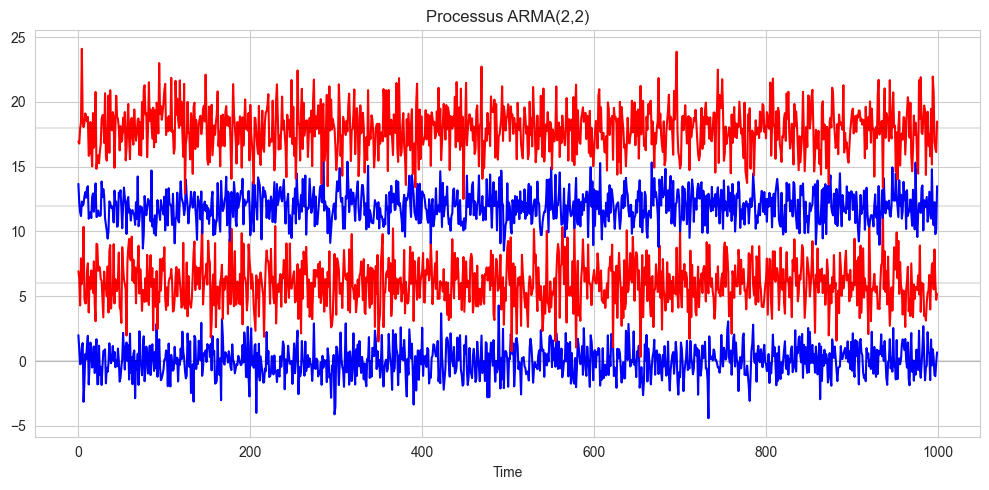

In [134]:
n_samples = 500 # nombre d'échantillon ARMA pour chacune des classe 
sample_size = 1000 # taille de chaque échantillon


torch.manual_seed(seed)
np.random.seed(2024)

param_classe1 = {'ar': [0.5*2, 0.5,0.2, 0.2*2,0.8], 'ma': [.6*2, 0.6,0.35]} # paramètres classe 1
param_classe2 = {'ar': [-0.4*2, -0.4,-0.15*2,-0.15,-0.75], 'ma': [-0.7*2, -0.7,-0.53]} # paramètres classe 2


# génération des échantillons

arma_data1 = arma_generate_sample(**param_classe1, nsample=(n_samples, sample_size))
arma_data2 = arma_generate_sample(**param_classe2, nsample=(n_samples, sample_size))


n_plots = 3
fig, ax = plt.subplots(figsize=(10, 5))
vertical_step = 6 # tracer les processus dans la mm fenêtres , plus il y'a de distance , plus les séries seront séparées

for i in range(0,n_plots-1):
    ax.plot(arma_data1[i, :]+(2*i)*vertical_step, color='blue')
    ax.axhline((2*i)*vertical_step, color='black', linestyle='-', alpha=0.1)
    ax.plot(arma_data2[i, :]+(2*i+1)*vertical_step, color='red')
    ax.axhline((2*i+1)*vertical_step, color='black', linestyle='-', alpha=0.1)

#ax.set_yticks([])

ax.set_xlabel('Time')
ax.set_title('Processus ARMA(2,2)')

plt.tight_layout()



D1,D2 = pd.DataFrame(arma_data1),pd.DataFrame(arma_data2)
D1['type'],D2['type'] = -1 ,1


D = pd.concat([D1, D2], axis=0)

# on mélange la data

D = D.sample(frac=1).reset_index(drop=True)

# split en variables explicatives et cible

X, y = D.iloc[:,:-1], D.iloc[:,-1]

print(f'X shape: {X.shape}')

<span style="color:orange; font-size:16px;"> Modèle 1 : regression logistique sur données brutes vs classification par regression logistique sur les termes de la signature</span>

In [138]:
tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

D1,D2 = pd.DataFrame(arma_data1),pd.DataFrame(arma_data2)
D1['type'],D2['type'] = -1,1
D = pd.concat([D1, D2], axis=0)

#etape de shuffle

D= D.sample(frac=1).reset_index(drop=True)

X, y = D.iloc[:,:-1], D.iloc[:,-1]


#avec L1 pénalisation
logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' )

#avec L2 pénalisation

logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l2' )


Accuracy: 0.49 +/- 0.03
Accuracy: 0.48 +/- 0.03


In [144]:
depth = 10 #
tensor_arma_data1 = torch.tensor(arma_data1).unsqueeze(2)
tensor_arma_data2 = torch.tensor(arma_data2).unsqueeze(2)

Hoff_LL_arma_data1 = compute_lead_lag_transform_Hoff_vok(tensor_arma_data1)
Hoff_LL_arma_data2 = compute_lead_lag_transform_Hoff_vok(tensor_arma_data2)

torch.manual_seed(seed)
np.random.seed(2024)
# signature terms

Sig_data1 = signatory.signature(Hoff_LL_arma_data1, depth=depth)
Sig_data2 = signatory.signature(Hoff_LL_arma_data2, depth=depth)

# nouveau dataset

D1_sig,D2_sig = pd.DataFrame(Sig_data1.numpy()),pd.DataFrame(Sig_data2.numpy())
D1_sig['type'],D2_sig['type'] = -1,1
D_sig = pd.concat([D1_sig, D2_sig], axis=0)

#etape de shuffle

D_sig = D_sig.sample(frac=1).reset_index(drop=True)

# predictors , variable to explain

X, y = D_sig.iloc[:,:-1], D_sig.iloc[:,-1]


#avec L1 pénalisation
logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l1' )

#avec L2 pénalisation

logistic_reg(seed=seed,predictors=X,cible=y,max_iter= 1000,solver_types='liblinear',penalty='l2' )

Accuracy: 0.46 +/- 0.04


<span style="color:orange; font-size:16px;"> Modèle 2 : classification par réseaux de neurones sur données brutes vs sur les termes de la signature</span>